In [2]:
%pwd
%pip install -r "requirements.txt"

  Using cached Flask-2.2.2-py3-none-any.whl (101 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


# Exploratory Data Analysis

In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, \
    Dropout, Flatten, Dense, Activation, \
    BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model


In [7]:
# dimensions of our images.
img_width, img_height = 64, 64
img_channels = 3
Image_Size = (img_width, img_height)

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (img_channels, img_width, img_height)
else:
    input_shape = (img_width, img_height, img_channels)

In [9]:
data_dir = './data/UTKFace'

filenames = os.listdir(data_dir)
size = len(filenames)
ages = []
genders = []

for file_name in filenames:
    age = file_name.split("_")[0]
    ages.append(int(age))

    gender = file_name.split("_")[1]
    if gender == '0':
        genders.append("male")
    else:
        genders.append('female')

df = pd.DataFrame({
    'filename': filenames,
    'age': ages,
    'gender': genders
})


In [10]:
df.head()

,filename,age,gender
0,100_0_0_20170112213500903.jpg.chip.jpg,100,male
1,100_0_0_20170112215240346.jpg.chip.jpg,100,male
2,100_1_0_20170110183726390.jpg.chip.jpg,100,female
3,100_1_0_20170112213001988.jpg.chip.jpg,100,female
4,100_1_0_20170112213303693.jpg.chip.jpg,100,female


<AxesSubplot:>

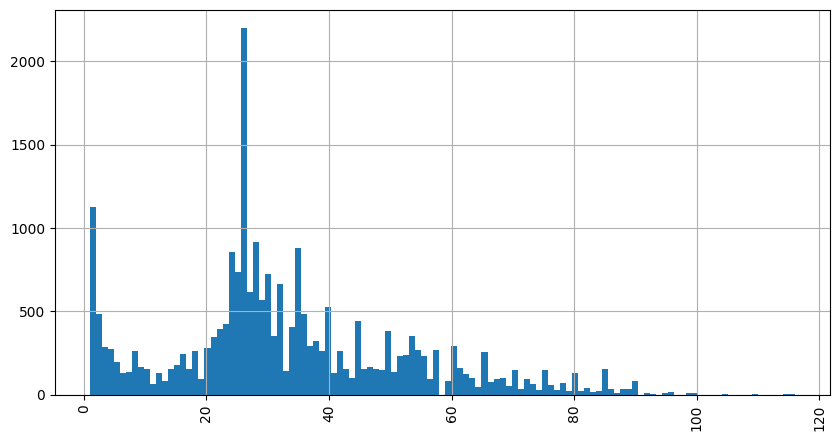

In [11]:
# histogram of df
df['age'].hist(bins=117, figsize=(10, 5), xrot=90)

<AxesSubplot:>

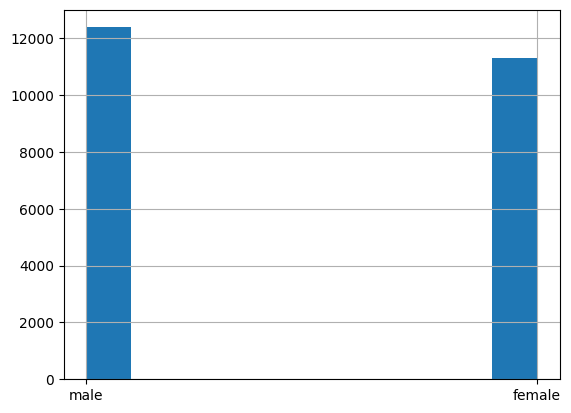

In [12]:
# histogram of df
df['gender'].hist()

# Training Model

In [14]:
data_dir = 'data/UTKFace/'

filenames = os.listdir(data_dir)
ages = []
genders = []
images = []

for file_name in filenames:
    age = file_name.split("_")[0]
    ages.append(int(age))

    gender = file_name.split("_")[1]
    genders.append(int(gender))

    image = cv2.imread(data_dir+file_name,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
df = pd.DataFrame({
    'filename': filenames,
    'age': ages,
    'gender': genders
})

df

,filename,age,gender
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1
...,...,...,...
23703,9_1_3_20161220222856346.jpg.chip.jpg,9,1
23704,9_1_3_20170104222949455.jpg.chip.jpg,9,1
23705,9_1_4_20170103200637399.jpg.chip.jpg,9,1
23706,9_1_4_20170103200814791.jpg.chip.jpg,9,1


Gender: 0 Age: 14
Gender shape: 64 Age shape: 64


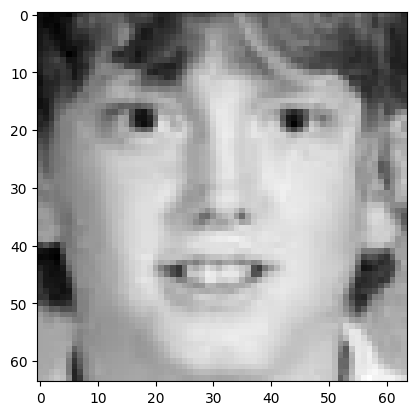

In [29]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [57]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4 #unknown
    
def get_gender(gend):
    if gend < 0.5:return "Male"
    else: return "Female"

In [58]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255

In [59]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [60]:
# y_gender = np.array(df['gender'])
# y_age = np.array(df['age'])

In [61]:
from tensorflow.keras import Input, Model

inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)

flatten = Flatten() (x)

# fully connected layers
dropout = Dropout(0.5)
age_model = Dense(128, activation='relu') (flatten)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu') (age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu') (age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu', name='age_out') (age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu') (flatten)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu') (gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu') (gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu') (gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu') (gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid', name='gender_out') (gender_model)

model = Model(inputs=inputs, outputs=[age_model,gender_model])

# mae = mean square error
model.compile(loss=['binary_crossentropy', 'mse'], optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 62, 62, 32)   320         ['input_8[0][0]']                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 60, 60, 64)   18496       ['conv2d_21[0][0]']              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 30, 30, 64)  0           ['conv2d_22[0][0]']              
 )                                                                                          

In [36]:
from tensorflow.keras.utils import plot_model

plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [62]:
# Train model
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 100, batch_size=128,shuffle = True)

Epoch 1/100
149/149 [==============================] - 225s 1s/step - loss: 1.5418 - age_out_loss: 1.2883 - gender_out_loss: 0.2535 - age_out_accuracy: 0.0109 - gender_out_accuracy: 0.5182 - val_loss: 0.9307 - val_age_out_loss: 0.6814 - val_gender_out_loss: 0.2494 - val_age_out_accuracy: 0.0278 - val_gender_out_accuracy: 0.5257
Epoch 2/100
149/149 [==============================] - 227s 2s/step - loss: 0.9730 - age_out_loss: 0.7236 - gender_out_loss: 0.2495 - age_out_accuracy: 0.0161 - gender_out_accuracy: 0.5216 - val_loss: 0.9310 - val_age_out_loss: 0.6817 - val_gender_out_loss: 0.2493 - val_age_out_accuracy: 0.0278 - val_gender_out_accuracy: 0.5257
Epoch 3/100
 37/149 [======>.......................] - ETA: 2:39 - loss: 0.9611 - age_out_loss: 0.7122 - gender_out_loss: 0.2489 - age_out_accuracy: 0.0220 - gender_out_accuracy: 0.5359

KeyboardInterrupt: 

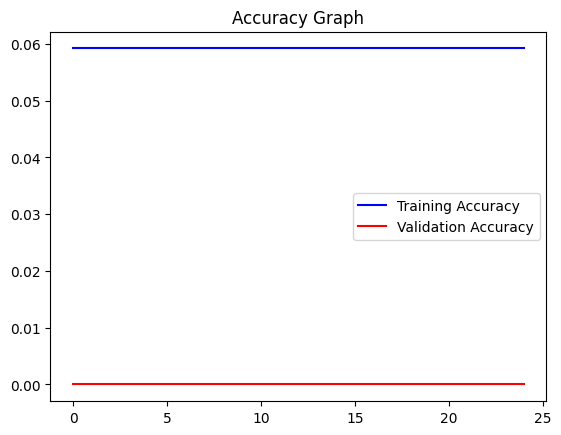

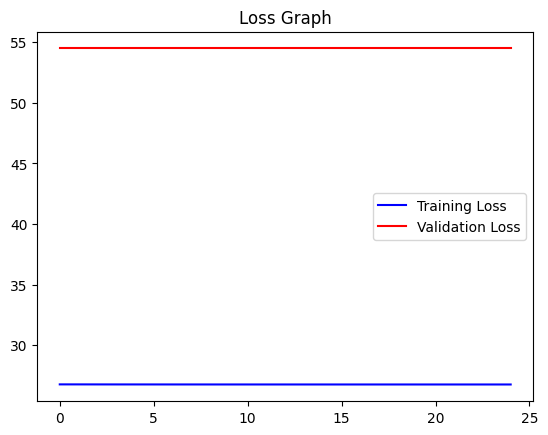

In [34]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

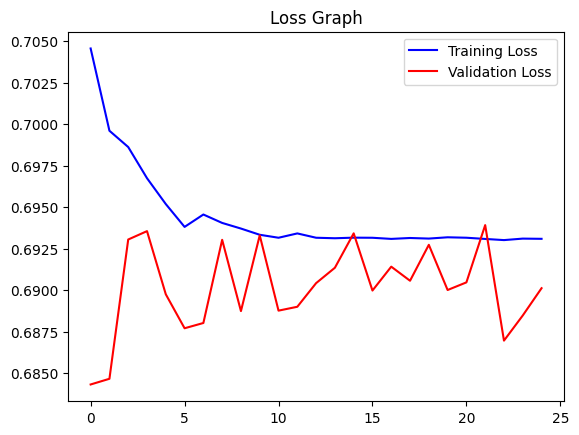

In [35]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
model.save("checkpoints/model.h5")

1/1 [==============================] - 0s 42ms/step
Original Gender: Male, Original Age: 10
Predicted Gender: Male, Predicted Age: 1


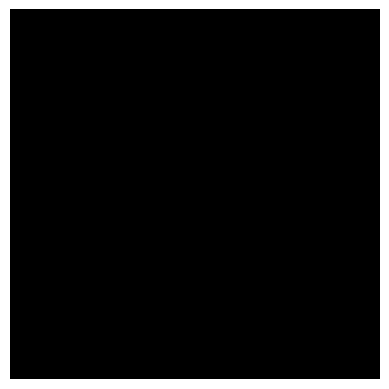

In [38]:
image_index = 100
gender_dict = {0:'Male', 1:'Female'}

# predict from model
pred = model.predict(X[image_index].reshape(1, 64, 64, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.axis('off')
plt.imshow(X[image_index]);

-------------------------------------------------------------------------------✈

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Hust/Age-Gender-Prediction"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Hust/Age-Gender-Prediction


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("checkpoints/model.h5")
%cd "./testimg"

[WinError 2] The system cannot find the file specified: './testimg'
c:\Users\Admin\Desktop\HUST.AI.Project\Age-Gender-Prediction


In [ ]:
%cd "../test-img/"
%ls

c:\Users\Admin\Desktop\HUST.AI.Project\test-img
 Volume in drive C is Dao Quang Duong
 Volume Serial Number is 94E6-1318

 Directory of c:\Users\Admin\Desktop\HUST.AI.Project\test-img

06/12/2022  04:22 CH    <DIR>          .
16/12/2022  03:37 CH    <DIR>          ..
06/12/2022  03:23 CH           101.882 evans.png
06/12/2022  03:17 CH            81.194 hermione.png
06/12/2022  03:29 CH           207.820 littlegirl.png
06/12/2022  03:08 CH            93.214 mixi.png
06/12/2022  03:22 CH            90.825 nguoiyeucu.png
06/12/2022  02:53 CH           188.804 phuong0.png
06/12/2022  02:57 CH           143.990 phuong1.png
06/12/2022  03:18 CH           108.811 thuytien.png
               8 File(s)      1.016.540 bytes
               2 Dir(s)  150.428.798.976 bytes free


In [ ]:
def testimg(path): 
    img = load_img(path, grayscale=False)
    img = img.resize((64, 64), Image.ANTIALIAS)
    img = np.array(img)
    gender_dict = {0:'Male', 1:'Female'}

    # predict from model
    pred = model.predict(img.reshape(1, 64, 64, 3))
    pred_gender = gender_dict[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])

    print(f"Predicted Gender: {pred_gender}, Predicted Age: {(pred_age)}")
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    return

1/1 [==============================] - 0s 32ms/step
Predicted Gender: Female, Predicted Age: 18


c:\Users\Admin\miniconda3\envs\ai_prj\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


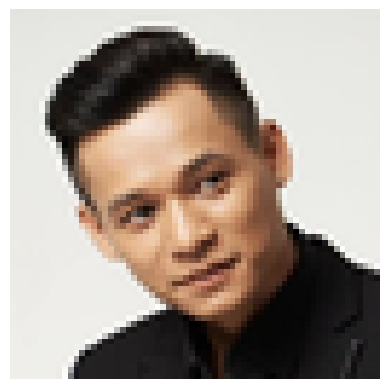

1/1 [==============================] - 0s 27ms/step
Predicted Gender: Female, Predicted Age: 11


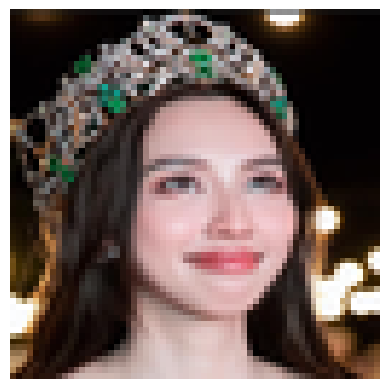

1/1 [==============================] - 0s 31ms/step
Predicted Gender: Male, Predicted Age: 11


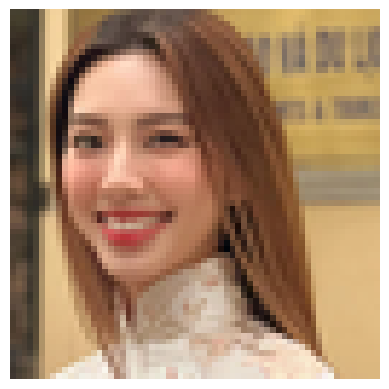

1/1 [==============================] - 0s 28ms/step
Predicted Gender: Female, Predicted Age: 12


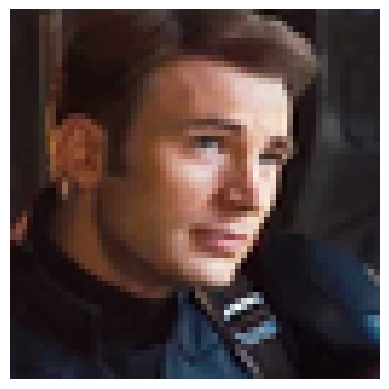

1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female, Predicted Age: 4


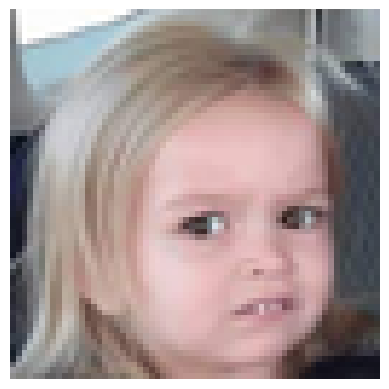

In [ ]:
# testimg("phuong0.png")
# testimg("phuong1.png")
testimg("mixi.png")
testimg("thuytien.png")
testimg("nguoiyeucu.png")
testimg("evans.png")
testimg("littlegirl.png")
